[GitHub.io Link](marklisi1.github.io)

# Final Tutorial: Employment in New Orleans
<p> Mark Lisi<br>
Sarper Tutuncuoglu </p>

In this tutorial, we aim to investigate patterns in employment in the city of New Orleans. We plan to focus predominantly on New Orleans City Service Departments in our analysis.
	

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

Another dataset we are considering working with is [city job applications.](https://data.nola.gov/City-Administration/City-Job-Applications-Submitted/ewwx-j8eu/data)

In [23]:
application_df = pd.read_csv("./data/City_Job_Applications_Submitted.csv")
application_df.head()

,City Job Title,Application Date
0,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
1,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
2,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
3,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM
4,311 TELECOMMUNICATIONS OPERATOR (CLASS CODE 7401),02/16/2018 12:00:00 AM


 This dataset doesn’t give us much - simply the title of the job applied for and the time of application - but it is considerably larger than the first dataset. We can at least determine which jobs are most frequently applied to at different times of year using this dataset.
	

For our collaboration plan, we are primarily using a combination of Github and Zoom meetings. We both have experience using Github to coordinate code in group projects, so we should be able to maintain an organized work environment. We have been meeting over Zoom on Sundays to touch base about work scheduling, but we are both able to have relatively flexible meeting patterns as the semester progresses.

## Requisition Requests

We can also take a look at the city job requisition requests.

In [24]:
req_df = pd.read_csv("./data/City_Jobs_Requisition_Requests.csv")
req_df.head()

,Req_Title,Req_Status,Department,Department_Code,Division,Job_Term,Received_Date,Req_Number,Description_Of_Duties_This_Sh
0,"Executive Counsel, City Council",Approved,City Council,200,Office of Chief of Staff,Unclassified,01/18/2019 11:38:37 AM,2019-00013,Representing the City Council's interests in l...
1,OFFICE ASSISTANT I (PROMOTIONAL) (CLASS CODE 0...,Filled,City Council,200,Council Research,Probationary,02/04/2019 10:53:57 AM,2019-00529,Promotion of Mary Hammothe from Office Assista...
2,Community Relations & Constituent Services Rep.,Approved,City Council,200,Council District D,Unclassified,02/13/2019 10:44:16 AM,2019-00570,The Community Relations & Constituent Services...
3,Constituent Services and Outreach,Approved,City Council,200,Council District B,Unclassified,02/20/2019 12:29:38 PM,2019-00673,Ms. Brock will be responsible for supporting t...
4,Legislative Aide,Approved,City Council,200,Council District A,Unclassified,03/04/2019 02:56:05 PM,2019-00745,Legislative Aide working part-time in Council ...


The `Req_Status` variable gives us a good preliminary impression of the demand for city jobs - how often city jobs requests are requested, versus how often they are fulfilled. 

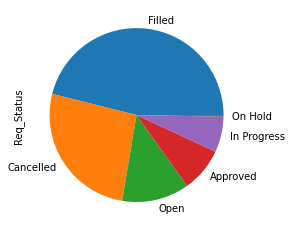

In [25]:
req_df['Req_Status'].value_counts().plot.pie()

We can map these values numerically to determine which city jobs are most or least likely to be filled. We can consider the values "Filled" or "Approved" as a full completion of the request (1), and "On Hold", "Open" or "Cancelled" as an incomplete request (0). We can map "In Progress" as a partial completion (0.5). We can then take the mean to determine the approximate probability that a request will be fulfilled. 

In [80]:
req_df["Req_Status_Num"] = req_df["Req_Status"].map({
       "Filled": 1,
       "Approved": 1,
       "In Progress": 0.5,
       "Cancelled": 0,
       "Open": 0,
       "On Hold": 0
})

req_df["Req_Status_Num"].mean()

0.576

The overall probability that a request will be fulfilled is ~57.6%. Now, we can inspect these probabilities by department.

In [81]:
req_df.groupby(['Department'])["Req_Status_Num"].mean().sort_values(ascending=False)

Department
Municipal Yacht Harbor                            1.000000
Coroner's Office                                  1.000000
Historic Districts and Landmarks Commission       1.000000
New Orleans Public Library                        1.000000
Law Department                                    0.961538
Juvenile Court                                    0.916667
Sanitation Department                             0.858824
Mayor's Office                                    0.855140
Vieux Carre Commission                            0.833333
Office Of Community Development                   0.833333
Parks & Parkways                                  0.802469
Clerk of Criminal District Court                  0.800000
City Council                                      0.791667
Municipal Court                                   0.784314
Civil Service Department                          0.767857
Health Department                                 0.699367
Fire Department                              

## New Orleans City Jobs Pay Plan


<p> The following code is to scrape the data in this PDF document which was retreived through the New Orleans city website. <a href="./data/nola_city_jobs_pay_plan.pdf"> New Orleans City Jobs Pay Plan</a> </p>

<p> The PDF was first converted into a text file using this tool: <a href="https://www.pdf2go.com/pdf-to-text"> PDF Converter</a></p>

In [28]:
f = open('./data/nola_city_jobs_pay_plan_edited_pay_grade_table.txt', 'r') 
raw_str = f.read()
f.close

raw_str = raw_str.replace('\n\n', '\n') #remove empty lines

raw_str = raw_str.replace(' ', '') #some numbers have spaces in between them, remove those spaces
raw_str = raw_str.replace('.', '') #remove all the decimal point dots to make all numbers consistent (all numbers in the PDF have 2 decimal points, so it can be fixed later)

raw_numbers = raw_str.split('\n') #every line as an element in a list

raw_numbers = [element for element in raw_numbers if element.isnumeric()] #remove titles/headers

data = {}
    
first_page_length = 85 - 34 + 1    
second_page_length = 135 - 86 + 1

for i, entry in enumerate(raw_numbers):
    
    if i < first_page_length: data.setdefault('Pay Grade', []).append(int(entry))
    elif i < 2*first_page_length: data.setdefault('Step 1', []).append(entry)
    elif i < 3*first_page_length: data.setdefault('Step 2', []).append(entry)
    elif i < 4*first_page_length: data.setdefault('Step 3', []).append(entry)
    elif i < 5*first_page_length: data.setdefault('Step 4', []).append(entry)
    elif i < 6*first_page_length: data.setdefault('Step 5', []).append(entry)
    elif i < 7*first_page_length: data.setdefault('Step 11', []).append(entry)
    elif i < 8*first_page_length: data.setdefault('Step 21', []).append(entry)
    elif i < 9*first_page_length: data.setdefault('Step 41', []).append(entry)
    elif i < 9*first_page_length + second_page_length: data['Pay Grade'].append(int(entry))
    elif i < 9*first_page_length + 2*second_page_length: data['Step 1'].append(entry)
    elif i < 9*first_page_length + 3*second_page_length: data['Step 2'].append(entry)
    elif i < 9*first_page_length + 4*second_page_length: data['Step 3'].append(entry)
    elif i < 9*first_page_length + 5*second_page_length: data['Step 4'].append(entry)
    elif i < 9*first_page_length + 6*second_page_length: data['Step 5'].append(entry)
    elif i < 9*first_page_length + 7*second_page_length: data['Step 11'].append(entry)
    elif i < 9*first_page_length + 8*second_page_length: data['Step 21'].append(entry)
    elif i < 9*first_page_length + 9*second_page_length: data['Step 41'].append(entry)
    
length = 135 - 34 + 1

for key in data:
    if(len(data[key]) != length):
        print("LENGTHS DON'T MATCH")
        
#LENGTHS MATCH!

#add decimal points to pay data and convert to float
data = {key: [float(elem[:-2] + '.' + elem[-2:]) for elem in data[key]] if key != 'Pay Grade' else data[key] for key in data}

In [29]:
pay_grades_df = pd.DataFrame(data)
pay_grades_df

,Pay Grade,Step 1,Step 2,Step 3,Step 4,Step 5,Step 11,Step 21,Step 41
0,34,15909.85,16108.73,16310.09,16513.96,16720.39,18014.26,20397.03,26149.75
1,35,16310.09,16513.96,16720.39,16929.39,17141.01,18467.44,20910.14,26807.58
2,36,16720.39,16929.39,17141.01,17355.27,17572.21,18932.01,21436.16,27481.95
3,37,17141.01,17355.27,17572.21,17791.87,18014.26,19408.26,21975.41,28173.30
4,38,17572.21,17791.87,18014.26,18239.44,18467.44,19896.50,22528.23,28882.03
...,...,...,...,...,...,...,...,...,...
97,131,177134.19,179348.36,181590.22,183860.09,186158.35,200563.87,227092.62,291141.19
98,132,181590.22,183860.09,186158.35,188485.33,190841.39,205609.31,232805.42,298465.21
99,133,186158.35,188485.33,190841.39,193226.91,195642.25,210781.66,238661.93,305973.48
100,134,190841.39,193226.91,195642.25,198087.77,200563.87,216084.14,244665.77,313670.63


This data shows the: 
<ul>
    <li>minimum (Step 1)</li>
    <li>2nd quartile (Step 11)</li>
    <li>midpoint (Step 21)</li>
    <li>maximum (Step 41)</li>
</ul>

salaries for the corresponding pay grades

This <a href="https://www.utdallas.edu/hr/compensation/standards/#:~:text=Second%20Quartile%3A%20The%20second%20quartile,experienced%20employee%20at%20that%20level."> UT Dallas </a> source helps us understand how salary quartiles work:

<img src="./src/salary_ranges_and_quartiles.png"/>

The following code is to scrape the rows that map city positions to min and max pay ranges in the <a href="./data/nola_city_jobs_pay_plan.pdf">PDF</a>

In [30]:
f = open('./data/nola_city_jobs_pay_plan_edited_positions_to_pay.txt', 'r') 
raw_str = f.read()
f.close

raw_str = raw_str.replace('\x0c', '') #remove the weirdly encoded characters
raw_str = raw_str.replace('\n\n', '\n') #remove empty rows

#characters to filter in
characters = list(string.ascii_uppercase) + list(string.ascii_lowercase) + list(string.digits) + [' ', ',', '(', ')', '\n']

#filter out all the characters that are not in the 'characters' list
raw_str = ''.join([character for character in raw_str if character in characters])

rows = raw_str.split('\n')
rows

data = []

for row in rows:
    line = row.strip()

    cleaned_row  = []
    elements = line.split(' ')
    elements = [element for element in elements if element != '']
    #print(elements)
    
    if len(elements) < 5: continue
    
    
    
    
    elem = elements.pop(0)

    if elem == 'EX':
        cleaned_row.append('EX')
        elem = elements.pop(0)
    else:
        cleaned_row.append(np.nan)

    if elem[0] == '(':
        cleaned_row.append(elem[1])
        elem = elements.pop(0)
    else:
        cleaned_row.append(np.nan)

    if elem[0] == 'C' or (len(elem) > 1 and elem[1].isnumeric()):
        cleaned_row.append(elem)
    else:
        cleaned_row.append(np.nan)

        
    if cleaned_row == [np.nan, np.nan, np.nan]: continue
    
    
    
    position = ''
    
    elem = elements.pop(0)
    while (not elem.isnumeric() or elem == '311' or elem == '911') and not elem =='Y':
        position += elem + ' '
        elem = elements.pop(0)
    
    cleaned_row.append(position.strip())
    
    if elem == 'Y':
        cleaned_row.append(True)
    elif elem.isnumeric():
        cleaned_row.append(False)
        cleaned_row.append(elem)
    
    cleaned_row += elements
        
    data.append(cleaned_row)
        
data = [row for row in data if len(row) == 10]

for row in data:
    
    row[6] = row[6].replace('(', '')
    row[6] = row[6].replace(')', '')
    row[9] = row[9].replace('(', '')
    row[9] = row[9].replace(')', '')
    
    row[6] = float(row[6].replace(',', ''))
    row[7] = float(row[7].replace(',', ''))
    try:
        row[9] = float(row[9].replace(',', ''))
    except ValueError:
        row[9] = np.nan


In [31]:
positions_to_pay_df = pd.DataFrame(data, columns=[
    'EAP', 'OC', 'Code', 'Position Class', 'EQP', 'Grade', 'Min', 'Max', 'Step', 'Rate'
])
positions_to_pay_df.head()

,EAP,OC,Code,Position Class,EQP,Grade,Min,Max,Step,Rate
0,NaN,NaN,C7401,311 TELECOMMUNICATIONS OPERATOR,False,50,23675.0,38914.0,09,26149.0
1,NaN,NaN,C7406,"311 TELECOMMUNICATIONS OPERATOR, DIVISION MANAGER",False,1,39893.0,65569.0,09,44061.0
2,NaN,NaN,C7405,"311 TELECOMMUNICATIONS OPERATOR, PRINCIPAL",False,61,31117.0,51144.0,09,34368.0
3,NaN,NaN,C7402,"311 TELECOMMUNICATIONS OPERATOR, SENIOR",False,56,27481.0,45169.0,09,30353.0
4,NaN,NaN,C7403,"311 TELECOMMUNICATIONS OPERATOR, SUPERVISOR",False,67,36119.0,59366.0,09,39893.0


A few values were scraped incorrectly, so we can manually fix them.

In [32]:
positions_to_pay_df.at[158, "Max"]= 97575.0
positions_to_pay_df.at[321, "Max"]= 79987.0
positions_to_pay_df.at[324, "Max"]= 78024.0
positions_to_pay_df.at[325, "Max"]= 70643.0
positions_to_pay_df.at[335, "Max"]= 78024.0
positions_to_pay_df.at[359, "Max"]= 72420.0
positions_to_pay_df.at[363, "Min"]= 56488.0
positions_to_pay_df.at[367, "Min"]= 52431.0
positions_to_pay_df.at[369, "Min"]= 55102.0
positions_to_pay_df.at[377, "Min"]= 57909.0
positions_to_pay_df.at[383, "Min"]= 52431.0
positions_to_pay_df.at[384, "Min"]= 55102.0
positions_to_pay_df.at[388, "Min"]= 52431.0
positions_to_pay_df.at[395, "Min"]= 59366.0
positions_to_pay_df.at[396, "Min"]= 53750.0
positions_to_pay_df.at[400, "Min"]= 59366.0

In [33]:
positions_to_pay_df['Range'] = positions_to_pay_df['Max'] -positions_to_pay_df['Min']
positions_to_pay_df

,EAP,OC,Code,Position Class,EQP,Grade,Min,Max,Step,Rate,Range
0,NaN,NaN,C7401,311 TELECOMMUNICATIONS OPERATOR,False,50,23675.0,38914.0,09,26149.0,15239.0
1,NaN,NaN,C7406,"311 TELECOMMUNICATIONS OPERATOR, DIVISION MANAGER",False,1,39893.0,65569.0,09,44061.0,25676.0
2,NaN,NaN,C7405,"311 TELECOMMUNICATIONS OPERATOR, PRINCIPAL",False,61,31117.0,51144.0,09,34368.0,20027.0
3,NaN,NaN,C7402,"311 TELECOMMUNICATIONS OPERATOR, SENIOR",False,56,27481.0,45169.0,09,30353.0,17688.0
4,NaN,NaN,C7403,"311 TELECOMMUNICATIONS OPERATOR, SUPERVISOR",False,67,36119.0,59366.0,09,39893.0,23247.0
...,...,...,...,...,...,...,...,...,...,...,...
657,NaN,2,8307,NETWORKS QUALITY ASSURANCE AND SAFETY INSPECTOR,False,73,41925.0,68909.0,13,48665.0,26984.0
658,NaN,7,3303,NETWORKS SENIOR MAINTENANCE TECHNICIAN,False,59,29608.0,48665.0,10,33111.0,19057.0
659,NaN,7,3304,NETWORKS SENIOR MAINTENANCE TECHNICIAN II,False,63,32702.0,53750.0,10,36570.0,21048.0
660,EX,1,3309,NETWORKS ZONE MANAGER,False,81,51144.0,84062.0,09,56488.0,32918.0


<ul>
    <li><strong>EAP</strong>: "EX" to indicate which classifications are exempt from the FLSA regulations on overtime</li>
    <li><strong>OC</strong>:  Occupational code as defined by the Federal Equal Employment Opportunity Commission</li>
    <li><strong>Code</strong>: Code for position class</li>
    <li><strong>Position Class</strong>: Description of job title</li>
    <li><strong>EQP</strong>:  Indicates positions where employees have been hired at a rate above the base rate</li>
    <li><strong>Grade</strong>: Pay grade (the corresponding pay grade in the <strong>pay_grades_df</strong> table)</li>
    <li><strong>Min</strong>: Minimum salary for position</li>
    <li><strong>Max</strong>: Maximum salary for position</li>
    <li><strong>Step</strong>: Pay grade step (the corresponding step in the <strong>pay_grades_df</strong> table)</li>
    <li><strong>Rate</strong>: Hiring rate (salary to which an employee is assigned upon entering the job)</li>
</ul>

In [34]:
positions_to_pay_df.dtypes

EAP                object
OC                 object
Code               object
Position Class     object
EQP                  bool
Grade              object
Min               float64
Max               float64
Step               object
Rate              float64
Range             float64
dtype: object

The histogram below shows the distribution of the hiring rates of city jobs. Hiring rate is the salary at which an employee is first hired for the position). We can see that it's highly skewed to the right, which is expected.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000271271E9F70>]],
      dtype=object)

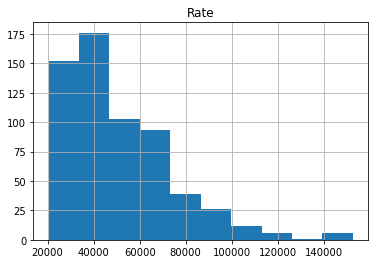

In [35]:
positions_to_pay_df.hist('Rate', bins=10)

In [36]:
positions_to_pay_df[['Min', 'Max', 'Rate']].describe()

,Min,Max,Rate
count,662.000000,662.000000,614.000000
mean,44513.821752,73578.504532,51238.956026
std,19693.719206,32106.099653,22865.071056
min,3232.000000,27481.000000,20397.000000
25%,30353.000000,50202.750000,34368.000000
50%,39893.000000,65569.000000,45169.000000
75%,55102.000000,90567.000000,63960.000000
max,128242.000000,210781.000000,152602.000000


## Correlating Applications and Pay Rate

Using the data we have now loaded in, we can draw some conclusions about how application rate compares to salary. First, we must extract the class codes from the application dataset.

In [37]:
application_df['Code'] = application_df["City Job Title"].str.replace("[^\d]", "", regex=True)
application_df['Code'] = application_df.Code.apply(lambda x: x[-4:])
application_df['City Job Title'] = application_df['City Job Title'].apply(lambda x: x.split(" (")[0])

application_df['Code'].value_counts()

        10830
7109     2820
0032     2462
3140     2288
8310     1939
        ...  
2241        1
2221        1
2211        1
4408        1
7132        1
Name: Code, Length: 448, dtype: int64

Many rows do not have the class codes. To resolve this, we can simply match them with rows that have the same title and do have a code. <br> (This cell may take a minute to run)

In [38]:
for index, row in application_df.iterrows():
    if row.Code == '':
        title_with_code = application_df[(application_df['City Job Title'] == row['City Job Title']) & (application_df.Code != '')]
        if title_with_code.size > 0:
            new_code = title_with_code.iloc[0].Code
            application_df.at[index, 'Code'] = new_code
        

We can also prepend a "C" to match the style of the payplan table.

In [39]:
application_df['Code'] = application_df['Code'].apply(lambda x: "C" + x)
application_df

,City Job Title,Application Date,Code
0,311 TELECOMMUNICATIONS OPERATOR,02/16/2018 12:00:00 AM,C7401
1,311 TELECOMMUNICATIONS OPERATOR,02/16/2018 12:00:00 AM,C7401
2,311 TELECOMMUNICATIONS OPERATOR,02/16/2018 12:00:00 AM,C7401
3,311 TELECOMMUNICATIONS OPERATOR,02/16/2018 12:00:00 AM,C7401
4,311 TELECOMMUNICATIONS OPERATOR,02/16/2018 12:00:00 AM,C7401
...,...,...,...
72022,ZONING ADMINISTRATOR,09/22/2018 12:00:00 AM,C4250
72023,ZONING ADMINISTRATOR,09/24/2018 12:00:00 AM,C4250
72024,ZONING ADMINISTRATOR,09/25/2018 12:00:00 AM,C4250
72025,ZONING ADMINISTRATOR,09/27/2018 12:00:00 AM,C4250


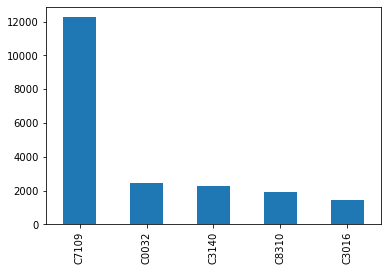

In [40]:
application_df['Code'].value_counts().head(5).plot.bar()

Finally, we can do a few merges to get a dataframe that contains the frequency of application to a given position, as well as the salary quartiles of that position. We no longer need the application date column, and can then drop duplicates. Let's see what the most commonly applied-to jobs are, as well as their salaries.

In [41]:
apps_and_pay = application_df.merge(positions_to_pay_df, on=["Code"])

freq_df = apps_and_pay["City Job Title"].value_counts().to_frame()
freq_df.reset_index(inplace=True)
freq_df.columns = ["City Job Title", 'freq']

freq_and_pay = freq_df.merge(apps_and_pay, on=["City Job Title"])

In [42]:
freq_and_pay = freq_and_pay.drop('Application Date', 1)
freq_and_pay = freq_and_pay.drop_duplicates()
freq_and_pay.sort_values(by=['freq'], ascending=False)
freq_and_pay.head(10)

,City Job Title,freq,Code,EAP,OC,Position Class,EQP,Grade,Min,Max,Step,Rate,Range
0,POLICE RECRUIT - ACADEMY,12247,C7109,NaN,4,POLICE RECRUIT,False,65,34368.0,56488.0,14,40391.0,22120.0
12247,RECREATION CENTER ASSISTANT I,1998,C6158,EX,4,RECREATION ADMINISTRATOR ll (SPECIAL PROGRAMS),False,82,52431.0,86176.0,09,57909.0,33745.0
12248,RECREATION CENTER ASSISTANT I,1998,C6158,NaN,5,RECREATION CENTER ASSISTANT,False,50,23675.0,38914.0,09,26149.0,15239.0
14245,UTILITIES PLANT WORKER,1452,C3016,NaN,5,UTILITIES PLANT WORKER,False,52,24882.0,40896.0,20,31505.0,16014.0
15697,NETWORKS MAINTENANCE TECHNICIAN I,1342,C3301,NaN,7,NETWORKS MAINTENANCE TECHNICIAN,False,52,24882.0,40896.0,15,29608.0,16014.0
17039,311 TELECOMMUNICATIONS OPERATOR,1228,C7401,NaN,NaN,311 TELECOMMUNICATIONS OPERATOR,False,50,23675.0,38914.0,09,26149.0,15239.0
18267,MANAGEMENT DEVELOPMENT ANALYST I,1192,C0361,NaN,NaN,MANAGEMENT DEVELOPMENT ANALYST,True,62,31899.0,52431.0,21,40896.0,20532.0
19459,GROUNDS PATROL OFFICER,1112,C7185,NaN,4,GROUNDS PATROL OFFICER,False,58,28882.0,47471.0,09,31899.0,18589.0
20571,OFFICE ASSISTANT IV,1084,C0132,NaN,6,OFFICE ASSISTANT IV,False,50,23675.0,38014.0,09,26149.0,14339.0
21655,AIRPORT SERVICES AGENT,1076,C8310,NaN,2,AIRPORT SERVICES AGENT,False,71,39893.0,65569.0,21,51144.0,25676.0


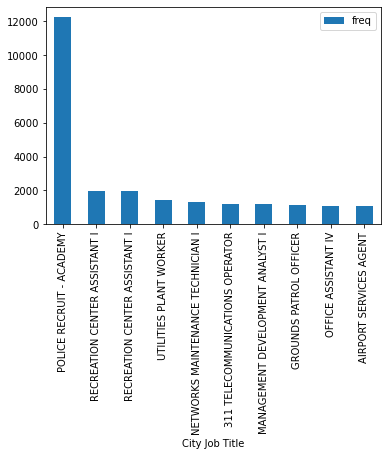

In [43]:
freq_and_pay = freq_and_pay.set_index("City Job Title")
ax = freq_and_pay.head(10)['freq'].plot.bar(legend=True)

Police recruit is the most frequently applied to city job by an absolutely staggering margin. Now, we can overlay the starting rates of each of these jobs.

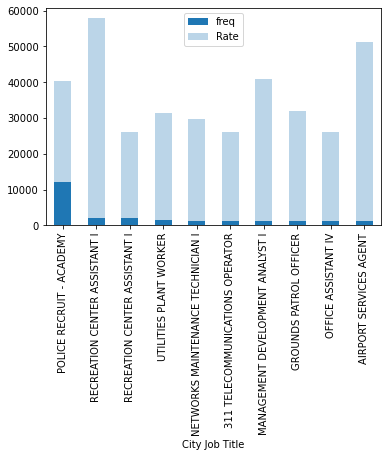

In [44]:
freq_and_pay.head(10)['Rate'].plot.bar(ax=ax, alpha=0.3, legend=True)
ax.figure

This plot indicates no meaningful relationship between application frequency and salary for the most popular jobs. We can take a look at every job using a scatter plot.

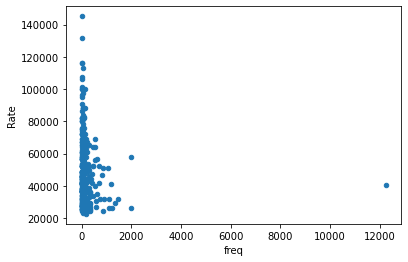

In [45]:
freq_and_pay = freq_and_pay.reset_index()
freq_and_pay.plot.scatter(x="freq", y="Rate")

Our plot is also heavily distorted by the significant outlier - police recruits. We can remove that for now and try to replot the data. 

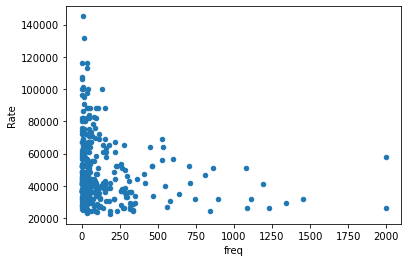

In [46]:
apps_without_police = freq_and_pay[1:] # We have already sorted our dataset on `freq`!
apps_without_police.plot.scatter(x="freq", y="Rate")

This plot shows something surprising - payrate and application frequency seem to be negatively correlated. We can use `.corr()` to generate a correlation matrix and confirm this.

In [47]:
freq_and_pay.corr()

,freq,EQP,Min,Max,Rate,Range
freq,1.000000,0.000466,-0.093957,-0.097935,-0.088663,-0.096849
EQP,0.000466,1.000000,0.174156,0.168680,0.180636,0.148904
Min,-0.093957,0.174156,1.000000,0.980458,0.972971,0.883353
Max,-0.097935,0.168680,0.980458,1.000000,0.975144,0.958299
Rate,-0.088663,0.180636,0.972971,0.975144,1.000000,0.907158
Range,-0.096849,0.148904,0.883353,0.958299,0.907158,1.000000


In [48]:
freq_and_pay

,City Job Title,freq,Code,EAP,OC,Position Class,EQP,Grade,Min,Max,Step,Rate,Range
0,POLICE RECRUIT - ACADEMY,12247,C7109,NaN,4,POLICE RECRUIT,False,65,34368.0,56488.0,14,40391.0,22120.0
1,RECREATION CENTER ASSISTANT I,1998,C6158,EX,4,RECREATION ADMINISTRATOR ll (SPECIAL PROGRAMS),False,82,52431.0,86176.0,09,57909.0,33745.0
2,RECREATION CENTER ASSISTANT I,1998,C6158,NaN,5,RECREATION CENTER ASSISTANT,False,50,23675.0,38914.0,09,26149.0,15239.0
3,UTILITIES PLANT WORKER,1452,C3016,NaN,5,UTILITIES PLANT WORKER,False,52,24882.0,40896.0,20,31505.0,16014.0
4,NETWORKS MAINTENANCE TECHNICIAN I,1342,C3301,NaN,7,NETWORKS MAINTENANCE TECHNICIAN,False,52,24882.0,40896.0,15,29608.0,16014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,CRIMINALIST II,1,C5251,NaN,2,CRIMINALIST II,False,71,39893.0,65569.0,9,44061.0,25676.0
375,CODE ENFORCEMENT ASSISTANT II,1,C5317,NaN,3,CODE ENFORCEMENT ASSISTANT II,False,54,26149.0,42980.0,09,28882.0,16831.0
376,AIRPORT SENIOR TRANSPORTATION OFFICER,1,C8055,NaN,7,AIRPORT SENIOR TRANSPORTATION OFFICER,False,64,33524.0,55102.0,9,37027.0,21578.0
377,"MOSQUITO TERMITE & RODENT CONTROL, ASSISTANT D...",1,C5429,NaN,NaN,"MOSQUITO TERMITE RODENT CONTROL, ASSISTANT DIR...",False,107,97575.0,160377.0,09,107770.0,62802.0


We can observe that min/max/rate are actually *negatively* correlated with frequency of application! This leads us to believe that other factors than pay may influence application frequency. 

## Requisition Request Description Analysis (NF-IDF Vectors!)

We can take a look at job descriptions to see what sorts of traits are common in city jobs. The `Description_Of_Duties` column in our requisition request dataframe (`req_df`) contains some of this information. We can use `sklearn` to do some text analysis with td-idf vectors.

In [182]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

`sklearn` will complain if we have any NaNs, so we can drop those. Additionally, we need some sort of metric to weight our vectors by - we can see which departments have high or low demand for new workers based on their number of requisition requests.

In [183]:
req_df = req_df[req_df['Description_Of_Duties_This_Sh'].notna()] # Fun fact, we only lose 5 out of 3876 rows doing this
req_df['Department'].value_counts()

Sewerage and Water Board of New Orleans           803
Miscellaneous                                     654
Police Department                                 625
Public Works Department                           183
Human Services                                    182
Health Department                                 160
New Orleans Aviation Board                        142
Fire Department                                   133
Chief Administrative Office                       128
Mayor's Office                                    109
Safety & Permits                                   92
Sanitation Department                              85
Property Management                                83
Parks & Parkways                                   81
Clerk of Criminal District Court                   60
Municipal Court                                    51
Finance Department                                 51
New Orleans Mosquito and Termite Control Board     38
Office Of Community Developm

We see that the departments with the most need (by a wide margin) are Sewerage and Water, Miscellaneous, and the Police Department. We will classify these three departments as "high" demand, and the others as "low". 

We will also add a column for whether a request was satisfied or not based on the mapping we applied earlier. This will become useful later! (Note: This is different than the given `Req_Status` column because it is binary, which is important for our purpose.)

In [184]:
req_df['demand'] = ''
req_df['s/u'] = ''

high_demand_depts = ["Sewerage and Water Board of New Orleans", "Miscellaneous", "Police Department"]

for i, row in req_df.iterrows():
    dept = row["Department"]
    if dept in high_demand_depts:
        req_df.at[i, "demand"] = "high"
    else:
        req_df.at[i, "demand"] = "low"
        
    if row['Req_Status_Num'] == 1.0 or row['Req_Status_Num'] == 0.5:
        req_df.at[i, "s/u"] = 'satisfied'
    else:
        req_df.at[i, "s/u"] = 'not satisfied'
        

We get a fairly even number of high and low demand requests this way, which is good!

In [185]:
req_df.demand.value_counts()

high    2082
low     1789
Name: demand, dtype: int64

Now, we can begin generating our vectors.

In [186]:
vec = TfidfVectorizer(min_df = 0.05, 
                      max_df = 0.85, 
                      ngram_range=(1,1)) # play with min_df and max_df

# transform this into a sparse vector!
vec.fit(req_df['Description_Of_Duties_This_Sh'])
tf_idf_sparse = vec.transform(req_df["Description_Of_Duties_This_Sh"])
tf_idf_sparse

<3871x207 sparse matrix of type '<class 'numpy.float64'>'
	with 104591 stored elements in Compressed Sparse Row format>

Now, we can make a model to classify the demand of a requisition request based on its description.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_sparse, 
                                                    req_df['demand'], 
                                                    test_size=0.2)

logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced') 
model = logisticRegr.fit(X_train, y_train)

Looking at our confusion matrix and accuracy score, we can see that our model correctly classifies descriptions 88% of the time.

0.9045161290322581


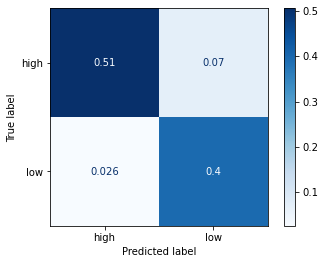

In [188]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=logisticRegr.classes_,
                                 cmap=plt.cm.Blues, normalize='all')

We can also see which individual words affect the demand most. We must also check the order of the classes in our array to see which one is negatively weighted and which one is positively weighted (the first class is negative, the second is positive).

In [189]:
logisticRegr.classes_

array(['high', 'low'], dtype=object)

High demand adds **negative** weight, where low demand adds **positive** weight.

In [190]:
descs = []
for w,i in vec.vocabulary_.items():
    descs.append([str(w)] + list(logisticRegr.coef_[:,i]))
df_weights = pd.DataFrame(descs, columns=['word', 'weight'])

In [191]:
df_weights.sort_values('weight', ascending=True)[:25]

,word,weight
129,police,-6.488048
163,water,-5.838313
172,facilities,-3.412494
114,professional,-2.698487
69,construction,-2.680226
59,training,-2.567890
22,position,-2.438188
16,department,-2.416471
91,performs,-2.416211
141,within,-2.247023


The above words are those that weight towards a high demand position. The top two come as no surprise - "police" and "water" correspond to the Police Department and the Sewerage and Water Board, two of our high demand departments. Below that, we see some more informative words - "manage", "enforcing", "professional". Let's take a look at our low-demand words.

In [192]:
df_weights.sort_values('weight', ascending=False)[:25]

,word,weight
1,city,3.707976
142,incumbent,2.837547
40,includes,2.482273
55,monitor,2.448617
35,be,2.281994
161,care,2.184742
93,assigned,2.121103
101,compliance,2.008878
38,public,1.847672
54,employee,1.823268


The word that most strongly indicates a low-demand department is *city!* This is generally telling of the way city jobs are treated in NOLA. Below that, we see even more interesting words: "care", "emergency", "compliance", "clerical", "regulations".

Based on our experience with city data, we can confirm that clerical work seems to be given quite low priority (ha-ha).

We can also analyze these descriptions in a different way - by the likelihood that their request will be filled (this is why we made that column earlier!). We can proceed in the same way, starting with retraining our model.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_sparse, 
                                                    req_df['s/u'], 
                                                    test_size=0.2)

logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced') 
model = logisticRegr.fit(X_train, y_train)

Checking our confusion matrix again, the model actually performs significantly worse (~23%) with this training.

0.6825806451612904


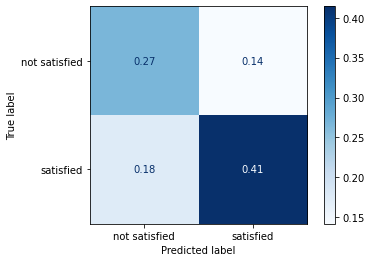

In [194]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=logisticRegr.classes_,
                                 cmap=plt.cm.Blues, normalize='all')

Checking our class order again, we see that unfulfilled requests give **negative** weight, where fulfilled requests give **positive** weight.

In [195]:
logisticRegr.classes_

array(['not satisfied', 'satisfied'], dtype=object)

In [196]:
descs = []
for w,i in vec.vocabulary_.items():
    descs.append([str(w)] + list(logisticRegr.coef_[:,i]))
df_weights = pd.DataFrame(descs, columns=['word', 'weight'])

First, let's look at the satisfied requests.

In [197]:
df_weights.sort_values('weight', ascending=False)[:25]

,word,weight
145,responsibility,1.988261
192,pool,1.953333
8,duties,1.659934
5,provide,1.465325
93,assigned,1.436340
140,tools,1.389624
39,which,1.362509
14,or,1.333057
74,projects,1.325217
122,supervisory,1.289388


It is easy and usually safe to retain an employee at their current position, which explains "Incumbent"'s position towards the top of the list. We also see "supervisory", "police", and "federal" pop up often in satisfied requisition requests.

Now, the unsatisfied requests:

In [199]:
df_weights.sort_values('weight', ascending=True)[:25]

,word,weight
163,water,-2.577493
78,maintenance,-2.388579
132,conducting,-1.797928
137,out,-1.763845
67,technical,-1.522819
82,up,-1.375403
134,under,-1.367847
156,specialized,-1.204069
111,include,-1.176537
30,service,-1.149070


"Maintenance" is hard to come by in New Orleans. "Technical" and "Specialized" positions are also less likely to be approved, perhaps because of their often-high salary costs. We see "clerical" pop up again, as well as (worryingly) "safety".